## Business Intelligence : 
### Applying Tree Based algorithm to credit scoring - case of Lending Club

Dataset obtained from the following Data Science competition website:
https://www.kaggle.com/wendykan/lending-club-loan-data

Project conducted back in December 2017 as part of a Business Intelligence Master class - aiming at proving the added value from a transparency perspective, of tree based algorithm, to identify decisive factors in loan delivery of credit institutions.

The useful feature_importance method helped to isolate these important factors.


****

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Modelling
#from xgboost import XGBClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# For styling of seaborn vizualization
sns.set(style='white', context='notebook')
sns.set_palette("PuOr")

In [2]:
# Data loading
loan = pd.read_csv('/Users/amaurylejay/Desktop/Core/BI/Final project/loan.csv')

/Users/amaurylejay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Preprocessing

In [3]:
#Dropping non-relevant columns for this analysis
droplist = ['verification_status_joint','pub_rec','recoveries','collection_recovery_fee','mths_since_last_record','initial_list_status','mths_since_last_major_derog','collections_12_mths_ex_med','url','open_rv_24m','sub_grade','max_bal_bc','open_rv_24m','total_rev_hi_lim','policy_code','annual_inc_joint', 'dti_joint', 'last_pymnt_d', 'next_pymnt_d','total_pymnt_inv', 'total_rec_int','earliest_cr_line', "issue_d","last_credit_pull_d"]
loan = loan.drop(droplist, axis=1)

In [4]:
#Removing columns with more than 20% missing values - could have found a better way - but accuracy not the point of this project
loan = loan.dropna(axis = 1,thresh = 0.2*loan.shape[0])

In [5]:
#column name remaining
loan.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_rec_prncp', 'total_rec_late_fee',
       'last_pymnt_amnt', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal'],
      dtype='object')

In [6]:
#Transforming the NAs of this columns into 0s
loan['mths_since_last_delinq'] = loan['mths_since_last_delinq'].fillna(0)
loan['tot_coll_amt'] = loan['tot_coll_amt'].fillna(0)
loan['tot_cur_bal'] = loan['tot_cur_bal'].fillna(0)
loan['total_acc'] = loan['total_acc'].fillna(0)
loan['acc_now_delinq'] = loan['acc_now_delinq'].fillna(0)
loan['revol_util'] = loan['revol_util'].fillna(0)

In [7]:
#Below are the column name which still have missing values.
for i in range(0,len(list(loan.columns.values))):
    if list(sum(list(loan.isnull().values== True)))[i] != 0:
        print(list(loan.columns.values)[i])
    else: 
        pass 


emp_title
emp_length
annual_inc
title
delinq_2yrs
inq_last_6mths
open_acc


In [8]:
# Given the number of remaining missing values, we decide to drop the rows where there are 29 missing values in the  column 
for i in range(0, loan.shape[1]):
    if list(sum(list(loan.isnull().values== True)))[i]==29:
        loan.dropna(subset = [str(list(loan.columns)[i])],how='any', inplace = True)
    else: pass

In [9]:
#Remaining missing value is only for the title / textual information columns, which we still want to keep. 
loan.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                 51450
emp_length                44825
home_ownership                0
annual_inc                    0
verification_status           0
loan_status                   0
pymnt_plan                    0
purpose                       0
title                       152
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
mths_since_last_delinq        0
open_acc                      0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_re

In [10]:
#Need to reset index because they are some missing values. 
loan.reset_index(inplace = True)

In [11]:
#Generating proper zip_codes
loan['zip_code'] = [str(loan['zip_code'][i]).replace('xx', '01')for i in range(0,loan.shape[0])]

In [12]:
#Isolating indexes
id_columns = loan[['id','member_id']].copy()

In [13]:
#Isolating default
default = loan.loc[loan['loan_status'] == 'Default']

In [14]:
#Dropping default instances from original dataframe
loan = loan.loc[loan['loan_status'] != 'Default']

In [15]:
#Need to reset index because they are some missing values (defaults)
loan.reset_index(inplace = True)

In [16]:
#Applying Reservoir Sampling to reduce the size of our dataset and make it computationally exploitable
from random import randrange

def reservoir_sampling(items, k):
    """ 
    Reservoir sampling algorithm for large sample space or unknow end list
    See <http://en.wikipedia.org/wiki/Reservoir_sampling> for detail>
    Type: ([a] * Int) -> [a]
    Prev constrain: k is positive and items at least of k items
    Post constrain: the length of return array is k
    """
    sample = items[0:k]

    for i in range(k, len(items)):
        j = randrange(1, i + 1)
        if j <= k:
            sample[j] = items[i]

    return sample

In [17]:
#Loan initial shape
loan.shape

(886131, 40)

In [18]:
#Isolating the indexes to later subselect them
loan_index = list(loan.index)

#K = number of SAFE elements to drop (we actually select them, to later drop them)
k = round(0.8 * (len(loan_index)))

loan = loan.drop(['index','id'], axis=1)
default = default.drop(['index','id'], axis = 1)

In [21]:
#Selecting the one that we will drop
indexes = reservoir_sampling(loan_index,k)

#Dropping the rows that are from
new_loan = loan.drop(loan.index[indexes])

#Dropping index column because we will append this dataframe to the other one anyway
new_loan = new_loan.drop(['level_0'],axis = 1)

#Appending the default and new_loan
final_loan = new_loan.append(default, ignore_index=True)

#Need to reset index to create a new index for the final df
final_loan.reset_index(inplace = True)

In [26]:
#Creating a single dataset loan
#final_loan.to_csv('final_loan.csv', sep = ';', encoding = 'utf-8')

In [27]:
#Converting Emp_lenght to proper format
final_loan["emp_length"].replace("10+ years","10",inplace=True)
final_loan["emp_length"].replace("< 1 year","0",inplace=True)
final_loan["emp_length"].replace("n/a","-1",inplace=True)
final_loan["emp_length"].replace(np.nan,"-1",inplace=True)
final_loan["emp_length"] = final_loan["emp_length"].apply(lambda x: x.split(" ")[0])
final_loan["emp_length"].unique()

array(['1', '0', '2', '7', '10', '4', '6', '5', '3', '8', '9', '-1'], dtype=object)

In [28]:
#Converting term to proper format
final_term = pd.DataFrame()
final_term = final_loan['term'].apply(lambda x: int(x.split(" ")[1]))
final_loan['term'] = final_term

In [29]:
#Converting the target variable into a proper format
final_loan["loan_status"].replace("Default",0,inplace=True)
final_loan["loan_status"].replace("Late",0,inplace=True)
final_loan["loan_status"].replace("Late (31-120 days)",0,inplace=True)
final_loan["loan_status"].replace("Late (16-30 days)",0,inplace=True)
final_loan["loan_status"].replace("Charged Off",0,inplace=True)
final_loan["loan_status"].replace("Does not meet the credit policy. Status:Charged Off",0,inplace=True)
final_loan["loan_status"].replace("Charged Off",0,inplace=True)

final_loan["loan_status"].replace("Issued",1,inplace=True)
final_loan["loan_status"].replace("Current",1,inplace=True)
final_loan["loan_status"].replace("In Grace Period",1,inplace=True)
final_loan["loan_status"].replace("Fully Paid",1,inplace=True)
final_loan["loan_status"].replace("Does not meet the credit policy. Status:Fully Paid",1,inplace=True)

final_loan["loan_status"].unique()


array([1, 0])

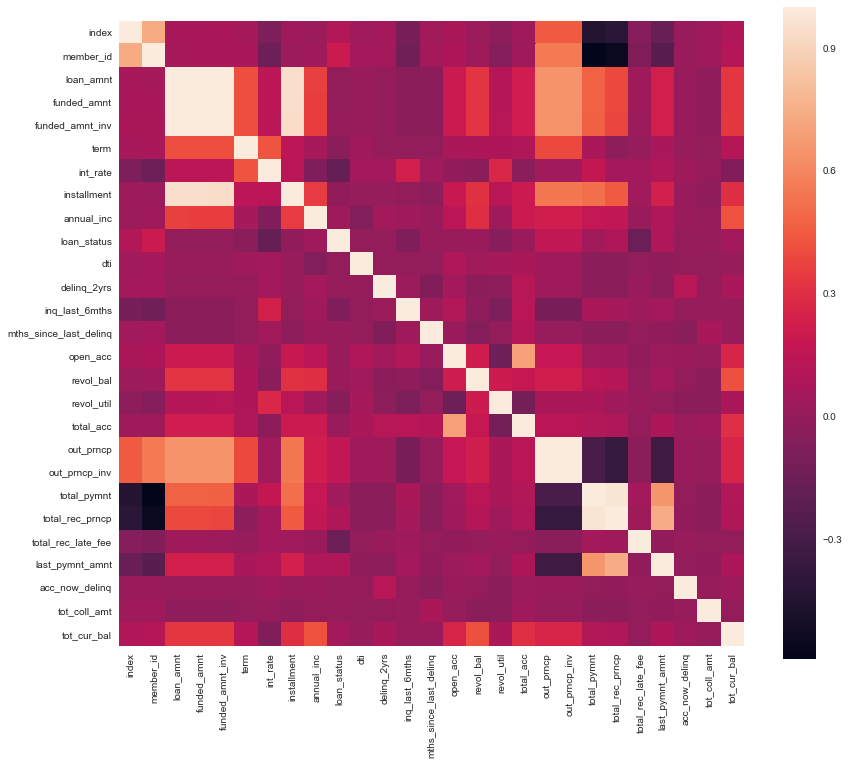

In [30]:
#Visualizing correlations
plt.figure(figsize = (14,12))
sns.heatmap(final_loan.corr(),square = True)
plt.show()

In [31]:
# We still have missing values
pd.DataFrame(final_loan.isnull().sum().sort_values( ascending = [False])).head()

,0
emp_title,10494
title,28
purpose,0
pymnt_plan,0
loan_status,0


In [32]:
#Dropping the last missing values columns emp_title and title
final_loan = final_loan.drop(['emp_title','title'], axis = 1)

In [33]:
#Isolating categorical features
categorical = list(final_loan.select_dtypes(include = ['object']).columns)
categorical

['grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'application_type']

In [34]:
#One-hot encodding of categorical features
for col in categorical:
    print("Modifying " + col)
    tmp = pd.get_dummies(final_loan[col], prefix=col)
    final_loan = pd.concat((final_loan, tmp), axis=1)
    
final_loan.drop(categorical, axis=1, inplace=True)

Modifying grade
Modifying emp_length
Modifying home_ownership
Modifying verification_status
Modifying pymnt_plan
Modifying purpose
Modifying zip_code
Modifying addr_state
Modifying application_type


In [35]:
#No more categorical variables now
list(final_loan.select_dtypes(include = ['object']).columns)

[]

In [36]:
#Dropping interest rates and other columns, which can be considered as cheating.
final_loan_int_rate = final_loan['int_rate']
final_loan = final_loan.drop(['int_rate'], axis = 1)
final_loan = final_loan.drop(['out_prncp_inv'], axis = 1)
final_loan = final_loan.drop(['out_prncp'], axis = 1)
final_loan = final_loan.drop(['total_rec_prncp'], axis = 1)
final_loan = final_loan.drop(['total_pymnt'], axis = 1)
final_loan = final_loan.drop(['index'], axis = 1)
final_loan = final_loan.drop(['member_id'], axis = 1)

In [37]:
#Splitting train and test 
y = final_loan['loan_status']
X = final_loan.loc[:, final_loan.columns != 'loan_status']
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2)

In [38]:
#Baseline model
sum(y_test == 1)/len(y_test)

0.9261677267505394

In [39]:
#Simple decision tree
accuracy=np.zeros(20)
depth=np.zeros(20)
table=pd.DataFrame(accuracy,depth)

for i in range(1,20):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    depth[i]=i
    accuracy[i] = clf.score(X_test, y_test)
    
table

,0
0.0,0.000000
1.0,0.926168
2.0,0.926644
3.0,0.926364
4.0,0.926420
5.0,0.926896
6.0,0.926980
7.0,0.927036
8.0,0.926280
9.0,0.925803


In [40]:
#max accuracy 
print("The maximum accuracy obtained with a simple decision tree is the following: " + str(max(table[0])*100)+ '% with a depth of 8')

The maximum accuracy obtained with a simple decision tree is the following: 92.70363417299447% with a depth of 8


In [41]:
#Random Forest
depth = np.arange(30,70,2)
i_max = 0
accuracy_max = 0

for i in depth:
    clf = RandomForestClassifier(max_depth = i, random_state=0)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print ('When the max depth is ' + str(i) + ' the accuracy is')
    print(accuracy_score(np.array(y_test), y_predict, normalize=True))
    print('')
    if (accuracy_score(np.array(y_test), y_predict, normalize=True)>accuracy_max):
        accuracy_max=accuracy_score(np.array(y_test), y_predict, normalize=True)
        i_max=i
        
print('The maximum accuracy of ' + str(accuracy_max) + ' is achieved with the max depth of ' + str(i_max))

When the max depth is 30 the accuracy is
0.926335845779

When the max depth is 32 the accuracy is
0.926083667236

When the max depth is 34 the accuracy is
0.926447925131

When the max depth is 36 the accuracy is
0.926475944969

When the max depth is 38 the accuracy is
0.926447925131

When the max depth is 40 the accuracy is
0.925943568046

When the max depth is 42 the accuracy is
0.926307825941

When the max depth is 44 the accuracy is
0.925719409342

When the max depth is 46 the accuracy is
0.926251786265

When the max depth is 48 the accuracy is
0.926644063997

When the max depth is 50 the accuracy is
0.926223766427

When the max depth is 52 the accuracy is
0.926279806103

When the max depth is 54 the accuracy is
0.926167726751

When the max depth is 56 the accuracy is
0.925775449018

When the max depth is 58 the accuracy is
0.92602762756

When the max depth is 60 the accuracy is
0.925943568046

When the max depth is 62 the accuracy is
0.925299111771

When the max depth is 64 the acc

In [42]:
#Our best model
clf = RandomForestClassifier(n_estimators = 36, max_depth=60)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [43]:
#Ranking the most important factors affecting the Random Forest Classifier:
print ("Features sorted by their score (Random Forest Classifier):")
feature_importance = clf.feature_importances_

Features sorted by their score (Random Forest Classifier):


In [44]:
#Isolating the importance of each factor to the model
major_factor = pd.DataFrame(clf.feature_importances_, columns = ['Importance'],index = X_train.columns)

In [45]:
#Sorting the factors
sorted_factors = major_factor.sort_values(["Importance"], ascending = [False])

In [46]:
#Most important factors
sorted_factors.head(15)

,Importance
last_pymnt_amnt,0.054034
tot_cur_bal,0.044140
installment,0.040348
dti,0.038895
revol_bal,0.038294
revol_util,0.038154
annual_inc,0.037882
funded_amnt_inv,0.035503
total_acc,0.034091
total_rec_late_fee,0.033164


In [51]:
selected_sorted_factor = sorted_factors[:30]

In [52]:
selected_sorted_factor.to_csv('sorted_factors.csv', sep = ';', encoding = 'utf-8')

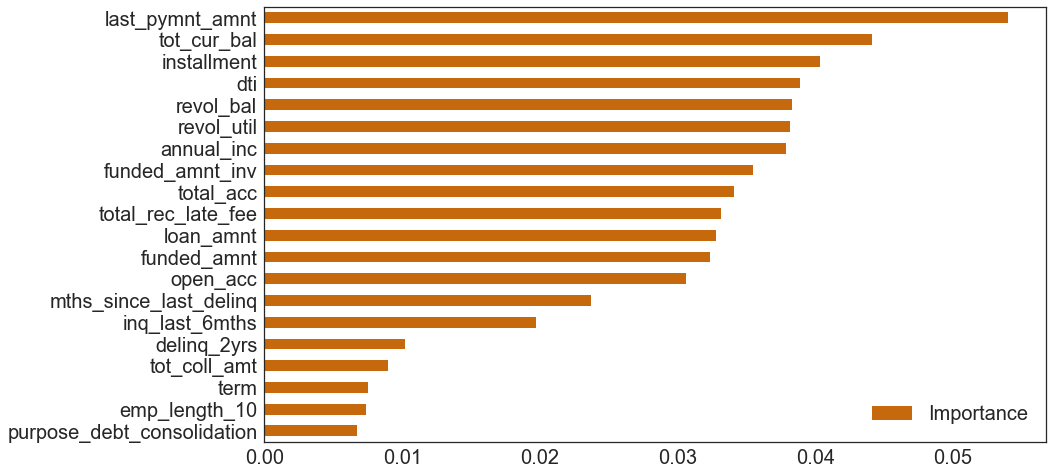

In [47]:
#Most important factors
plot = sorted_factors[:20].plot(kind = 'barh',figsize= (14,8))
plot.tick_params(axis = 'both',labelsize = 20)
plot.legend(prop= {'size':20})
plt.gca().invert_yaxis()
plt.show()

In [53]:
final_loan.shape

(178445, 1009)

****

To do:

Explore other algorithms (log reg, XG Boost, DL with Lime for explanation...)


...